In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [ ]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../data/"
TRIPS_PATH += "NYC_Pilot2_PM_Part1.csv"

if IN_COLAB:
    POLYGON_PATH = "/content/drive/MyDrive/Project/"
else:
    POLYGON_PATH = "../data/"
POLYGON_PATH += "nyc_polygon.geojson"

if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE.csv"

In [2]:
TRIPS_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/NYC_Pilot2_PM_Part1.csv'
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [15]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt

import h3

In [4]:
h3_resolution = 9

In [5]:
trips = pd.read_csv(TRIPS_PATH)

In [6]:
trips['h3'] = trips.apply(lambda x: h3.geo_to_h3(x.latitude, x.longitude, resolution=h3_resolution), axis = 1)

In [7]:
from shapely.geometry import Polygon
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3'], True)
  return Polygon(points)

In [8]:
reference_value = pd.read_csv(REF_PATH)
reference_value['neighborhood'].nunique()

48

In [11]:
neighborhoods = gpd.read_file(POLYGON_PATH)

In [12]:
def get_rmse_h3(baseline, encoded):
    error = []
    for sampling_frequency in np.arange(0.1,1.1,0.1):
        sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        df_pm25 = (sampled_trips
                          .groupby('h3')
                          .pm25
                          .agg(list)
                          .to_frame("pm25_list")
                          .reset_index())# Let's count each points inside the hexagon

        df_pm25['average_pm25_value'] = df_pm25['pm25_list'].apply(lambda x:sum(x)/len(x))
        df_pm25.drop('pm25_list', axis = 1, inplace=True)
        from shapely.geometry import Polygon
        df_pm25['geometry'] = (df_pm25.apply(add_geometry,axis=1))
        gdf_pm25 = gpd.GeoDataFrame(df_pm25, geometry = df_pm25.geometry)
        gdf_pm25.set_crs('epsg:4326', inplace = True)
        filtered_neighborhoods = gpd.GeoDataFrame(sampled_trips, geometry = gpd.points_from_xy(sampled_trips.longitude, sampled_trips.latitude))
        filtered_neighborhoods = filtered_neighborhoods.set_crs('epsg:4326')
        filtered_sjoin = gpd.sjoin(neighborhoods, filtered_neighborhoods, how = 'inner')
        filtered_sjoin.drop('index_right', axis = 1,inplace=True)
        sjoined_trips_original = gpd.sjoin(filtered_sjoin, gdf_pm25, how='inner').reset_index(drop = True)
        sjoined_trips = sjoined_trips_original[['neighborhood', 'average_pm25_value']]

        for neighborhds in baseline['neighborhood']:
            if neighborhds not in sjoined_trips['neighborhood']:
                sjoined_trips.loc[len(sjoined_trips.index)] = [neighborhds, 0]
        baseline_pm25 = baseline['average_pm25_value'].tolist()
        sampled_pm25 = sjoined_trips.groupby('neighborhood')['average_pm25_value'].mean().tolist()

        rmse = math.sqrt(np.square(np.subtract(baseline_pm25,sampled_pm25).mean()))
        error.append(rmse)
    return error

In [13]:
RMSE_H3 = get_rmse_h3(reference_value,trips)

C:\Users\mohan\AppData\Local\Temp\ipykernel_15596\3138646160.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_trips = encoded.groupby('h3').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\mohan\AppData\Local\Temp\ipykernel_15596\3138646160.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sjoined_trips.loc[len(sjoined_trips.index)] = [neighborhds, 0]
C:\Users\mohan\AppData\Local\Temp\ipykernel_15596\3138646160.py:27: SettingWithCopyWarning: 
A value is trying to 

<Figure size 700x350 with 0 Axes>

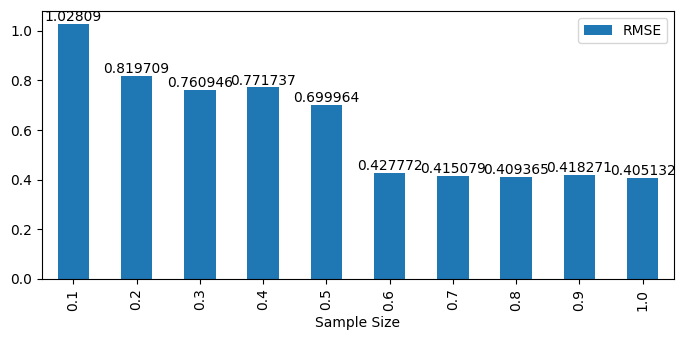

In [24]:
H3_Performance = pd.DataFrame({'Sample Size':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
                               'RMSE': RMSE_H3})
plt.figure()
ax = H3_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
ax.bar_label(ax.containers[0], color = 'black')
plt.show()